In [3]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley.kriging import KrigingIndices
from shapley.tests.test_functions import ishigami, ishigami_true_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dim = 3
model = ot.PythonFunction(dim, 1, ishigami)
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)

## Sobol indices

In [5]:
columns_first = ['n_sample']
for i in range(dim):
    columns_first.append('S_%d' % (i+1))
    columns_first.append('S_%d_down' % (i+1))
    columns_first.append('S_%d_up' % (i+1))
    
columns_total = ['n_sample']
for i in range(dim):
    columns_total.append('St_%d' % (i+1))
    columns_total.append('St_%d_down' % (i+1))
    columns_total.append('St_%d_up' % (i+1))

In [6]:
n_exp = 10
alpha = 0.95
n_samples = np.linspace(100, 10000, n_exp)
results_first = pd.DataFrame(np.zeros((n_exp, len(columns_first))), columns=columns_first)
results_total = pd.DataFrame(np.zeros((n_exp, len(columns_total))), columns=columns_total)
for k, n_sample in enumerate(n_samples):
    results_first.loc[k, 'n_sample'] = int(n_sample)
    results_total.loc[k, 'n_sample'] = int(n_sample)
    input_design = ot.SobolIndicesAlgorithmImplementation.Generate(input_distribution, int(n_sample), True)
    output_design = model(input_design)
    sensitivity = ot.SaltelliSensitivityAlgorithm(input_design, output_design, int(n_sample))
    sensitivity.setBootstrapConfidenceLevel(alpha)
    indices = np.asarray(sensitivity.getFirstOrderIndices())
    indices_intervals = sensitivity.getFirstOrderIndicesInterval()
    indices_interval_down = np.asarray(indices_intervals.getLowerBound())
    indices_interval_up = np.asarray(indices_intervals.getUpperBound())
    total_indices = np.asarray(sensitivity.getTotalOrderIndices())
    total_indices_intervals = sensitivity.getTotalOrderIndicesInterval()
    total_indices_intervals_down = np.asarray(total_indices_intervals.getLowerBound())
    total_indices_intervals_up = np.asarray(total_indices_intervals.getUpperBound())
    for i in range(dim):
        results_first.loc[k, 'S_%d' % (i+1)] = indices[i]
        results_first.loc[k, 'S_%d_down' % (i+1)] = indices_interval_down[i]
        results_first.loc[k, 'S_%d_up' % (i+1)] = indices_interval_up[i]
        results_total.loc[k, 'St_%d' % (i+1)] = total_indices[i]
        results_total.loc[k, 'St_%d_down' % (i+1)] = total_indices_intervals_down[i]
        results_total.loc[k, 'St_%d_up' % (i+1)] = total_indices_intervals_up[i]

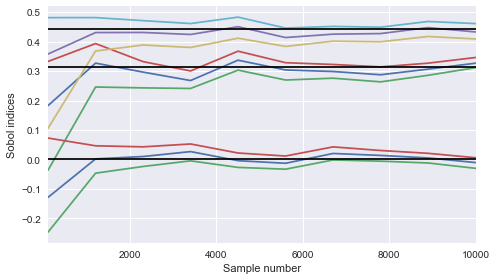

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
results_first.plot(x='n_sample', legend=False, ax=ax)
x = [n_samples[0], n_samples[-1]]
for i in range(dim):
    true_indice = ishigami_true_indices[i]
    ax.plot(x, [true_indice]*2, 'k')
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

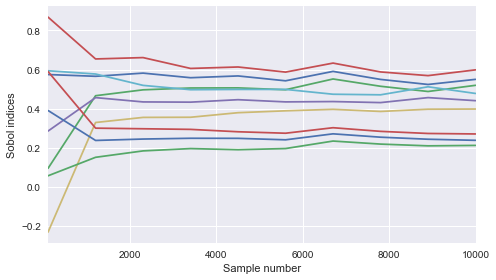

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
results_total.plot(x='n_sample', legend=False, ax=ax)
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

## Sobol with kriging

In [28]:
n_realization = 50
n_bootstrap = 1
kriging = KrigingIndices(model, input_distribution)
kriging.build_model(n_sample_kriging=200)

In [29]:
first_indices = kriging.compute_indices(n_sample=500, n_realization=n_realization, n_bootstrap=n_bootstrap)

In [30]:
first_indices_estimates = [first_indices[i, :, 0].mean() for i in range(dim)]
first_indices_estimates

[0.37998255758602034, 0.42141838867928127, -0.050298164942768259]

In [31]:
first_indices_estimates = [first_indices[i].mean() for i in range(dim)]
first_indices_estimates

[0.37998255758602034, 0.42141838867928127, -0.050298164942768259]

In [32]:
first_indices_std = [first_indices[i].std() for i in range(dim)]
first_indices_std

[0.044576769618085495, 0.042672350887594489, 0.026815913832979071]

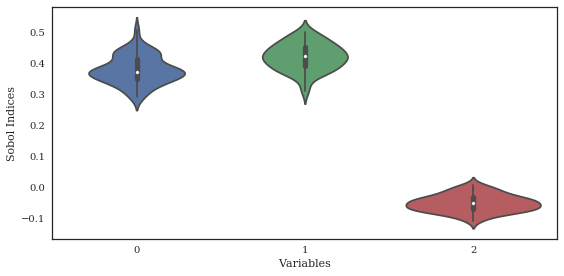

In [72]:
set_style_paper()
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=first_indices[:, :, 0].T, ax=ax);

ax.set_xlabel('Variables')
ax.set_ylabel('Sobol Indices')
fig.tight_layout()

In [73]:
i = 0
for i_nz in range(n_realization):
    for i_b in range(n_bootstrap):
        pass

In [ ]:
def sobol_estimator(sample_1, sample_2):
    